# ELMo Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo to study semantic change of conversion.

In [1]:
import numpy as np
import pandas as pd
import allennlp.commands.elmo
import matplotlib.pyplot as plt
import seaborn as sns
import conllu
import sklearn.decomposition

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read the CoNLL-U file

In [2]:
UD_FILE = "../data/en_ewt-ud-train.conllu"

with open(UD_FILE, "r", encoding="utf-8") as data_file:
  data = data_file.read()
  data = conllu.parse(data)

In [3]:
data[:3]

[TokenList<Al, -, Zaman, :, American, forces, killed, Shaikh, Abdullah, al, -, Ani, ,, the, preacher, at, the, mosque, in, the, town, of, Qaim, ,, near, the, Syrian, border, .>,
 TokenList<[, This, killing, of, a, respected, cleric, will, be, causing, us, trouble, for, years, to, come, ., ]>,
 TokenList<DPA, :, Iraqi, authorities, announced, that, they, had, busted, up, 3, terrorist, cells, operating, in, Baghdad, .>]

## ELMo embeddings of instances of a fixed lemma

In [4]:
elmo = allennlp.commands.elmo.ElmoEmbedder(cuda_device=0)

In [5]:
FIXED_LEMMA = "work"

In [6]:
noun_embeddings = []
verb_embeddings = []

for token_list in data:
  tokens_for_elmo = [t['form'] for t in token_list]
  
  # Skip if it doesn't contain the word
  if FIXED_LEMMA not in [t['lemma'] for t in token_list]:
    continue
  
  embeddings = elmo.embed_sentence(tokens_for_elmo)[2]
  for i in range(len(token_list)):
    if token_list[i]['lemma'] == FIXED_LEMMA:
      if token_list[i]['upostag'] == 'NOUN':
        noun_embeddings.append(embeddings[i])
      elif token_list[i]['upostag'] == 'VERB':
        verb_embeddings.append(embeddings[i])

print(len(noun_embeddings))
print(len(verb_embeddings))

118
223


In [7]:
noun_embeddings = np.vstack(noun_embeddings)
verb_embeddings = np.vstack(verb_embeddings)

## Apply PCA and plot

In [8]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)

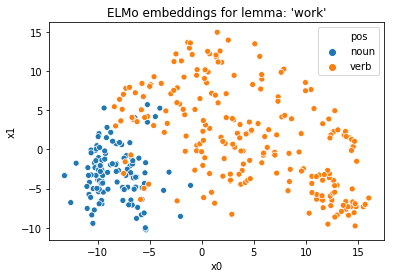

In [9]:
plot = sns.scatterplot(data=all_embeddings_df, x='x0', y='x1', hue='pos')
plot.set(title="ELMo embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()